In [1]:
import Pkg
Pkg.activate("../Project.toml")
using Distributions
using Random
using Plots
using SigmoidalProgramming

  Activating environment at `~/Projects/MINDResourceAllocation/Project.toml`


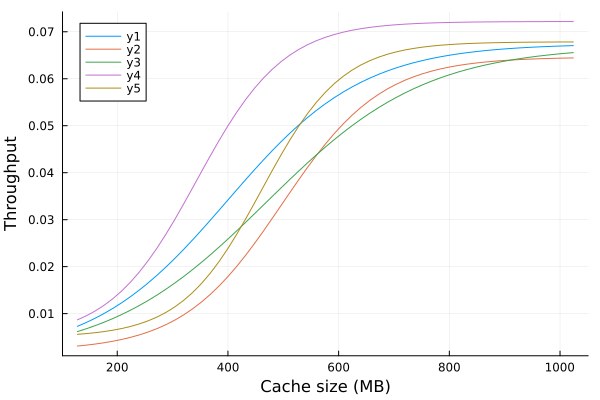

┌ Warning: The GLPK constants have been renamed from `GLPK.XXX` to `GLPK.GLP_XXX` in order to better match the C API. For example, `GLPK.MSG_OFF` is now `GLPK.GLP_MSG_OFF`. Support for the old constants will be removed in a future release.
└ @ GLPK /Users/antonsquared/.julia/packages/GLPK/JpN1q/src/MOI_wrapper/deprecated_constants.jl:19


iteration: 1
iteration: 2
iteration: 3
found solution within tolerance 0.0018296871527272995 in 3 iterations
total throughput lower bound: 0.19615099345521048
total throughput upper bound: 0.19798068060793778
optimal resource allocations: [608.7590428396205, 128.0, 144.97883841641328, 523.8454747951055, 642.4166439488606]
[2047.9999999999998]


In [2]:
Random.seed!(28)



# generate arbitrary sigmoid relations between resource allocation (cache) and throughput
function C_rand()
    return rand(Uniform(0, 0.005))
end

function L_rand()
    return rand(Uniform(0.06, 0.07))
end

function c1_rand()
    return rand(Uniform(0.005, 0.015))
end
            
function c2_rand()
    return rand(Uniform(300, 500))
end

function C_rand_2()
    return rand(Uniform(0, 0.005)) # y intercept
end

function L_rand_2()
    return rand(Uniform(0.005, 0.01)) # max
end

function c1_rand_2()
    return rand(Uniform(0.005, 0.015)) # strength
end
            
function c2_rand_2()
    return rand(Uniform(700, 900)) # center
end
                                

                
# BASIC sigmoid                                      
function gen_log_funct(C, L, c1, c2, C2, L2, c12, c22)
    function(x)
        C + L/(1 + exp(-c1 * (x - c2)))
    end
end
            

function gen_log_funct_prime(C, L, c1, c2, C2, L2, c12, c22)
    function(x)
        (c1 * L * exp(-c1 * (x - c2)) )/(1 + exp(-c1 * (x - c2)))^2
    end
end
                
function get_z(C, L, c1, c2, C2, L2, c12, c22)
    return c2                
end
      
# DIFFERENCES of sigmoids
function gen_log_funct_2(C, L, c1, c2, C2, L2, c12, c22)
    function(x)
        C + L/(1 + exp(-c1 * (x - c2)))  - L2/(1 + exp(-c12* (x - c22)))
    end
end
            
    
function gen_log_funct_prime_2(C, L, c1, c2, C2, L2, c12, c22)
    function(x)
        (c1 * L * exp(-c1 * (x - c2)))/(1 + exp(-c1 * (x - c2)))^2 - (c12 * L2 * exp(-c12 * (x - c22)) )/(1 + exp(-c12 * (x - c22)))^2
    end
end

function compute_z(C, L, c1, c2, C2, L2, c12, c22) 
    # this is inaccurate...there's no singular z inflection from concave to convex, 
    # resulting in a poor approximation
    return c2                
end
                
                
# INCOMPLETE: sigmoid minus a convex function to simulate the observed crowding out effect
function gen_log_funct_3(C, L, c1, c2, C2, L2, c12, c22)
    function(x)
        C + L/(1 + exp(-c1 * (x - c2)))  - L2/(1 + exp(-c12* (x - c22)))
    end
end
            

function gen_log_funct_prime_3(C, L, c1, c2, C2, L2, c12, c22)
    function(x)
        (c1 * L * exp(-c1 * (x - c2)))/(1 + exp(-c1 * (x - c2)))^2 - (c12 * L2 * exp(-c12 * (x - c22)) )/(1 + exp(-c12 * (x - c22)))^2
    end
end
            
      
function gen_eqn_list(n, eqn_func, eqn_prime_func, compute_z)
    eqn_list = Array{Function, 1}(undef, n)
    eqn_prime_list = Array{Function, 1}(undef, n)
    z_list = fill(0.0, n)
    for i in 1:n
        C = C_rand()
        L = L_rand()
        c1 = c1_rand()
        c2 = c2_rand()
        C2 = C_rand_2()
        L2 = L_rand_2()
        c12 = c1_rand_2()
        c22 = c2_rand_2()
        eqn_list[i] = eqn_func(C, L, c1, c2, C2, L2, c12, c22)
        eqn_prime_list[i] = eqn_prime_func(C, L, c1, c2, C2, L2, c12, c22)
        z_list[i] = compute_z(C, L, c1, c2, C2, L2, c12, c22)
    end
    return [eqn_list, eqn_prime_list, z_list]
end
            
            

function gen_range(eqn)
    X_range = range(128, 1024, length = 57)
    Y = eqn.(X_range)
    return Y
end
            
function plot_eqn_list(eqn_list)
    X_range = range(128, 1024, length = 57)
    
    res_list = gen_range.(eqn_list)
    display(plot(X_range, res_list, xlabel="Cache size (MB)", ylabel = "Throughput"))
end
 

# simulation parameters
nvar = 5            
nineqconstr = 1
l = ones(nvar) * 128 # resource lower bound (starvation prevention) 
u = ones(nvar) * 1024 # individual resource upper bound
A= ones(1, nvar)                
b = [2048.] # total resources available


fs, dfs, z = gen_eqn_list(nvar, gen_log_funct, gen_log_funct_prime, get_z)
# println(fs)

plot_eqn_list(fs)


# using sigmoidal programming 

problem = SigmoidalProgramming.LinearSP(fs, dfs, z, A, b)  
pq, bestnodes, lbs, ubs = SigmoidalProgramming.solve_sp(l, u, problem, verbose=true, TOL=1e-2, maxiters=1000)

# the best node found yet is the top node on the priority queue
node = bestnodes[end]

println("total throughput lower bound: ",lbs[end])
println("total throughput upper bound: ",ubs[end])
println("optimal resource allocations: ", node.x)
                    
println(A * node.x)

In [3]:
println(z)

[399.0678798078551, 497.833653766564, 469.24523649204014, 343.6195575843768, 461.26674450311253]
